<a href="https://colab.research.google.com/github/Vika41/forecast-project/blob/main/Analytical_System_Design_Project_Elers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
!pip install cassandra-driver
!pip install cassio
!pip install mlflow

In [56]:
import cassandra
import csv
import joblib
import json
import logging
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn
import time
import uuid

from cassandra.cluster import Cluster
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from uuid import uuid4

In [57]:
def get_weather_forecast(api_key, city):
  url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={api_key}"
  response = requests.get(url)

  if response.status_code == 200:
    data = response.json()
    return data
  else:
    return None

def save_to_csv(data, filename):
  with open(filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Date & Time', 'Temperature', 'Weather Description'])
    for entry in data['list']:
      csv_writer.writerow([entry['dt_txt'], entry['main']['temp'], entry['weather'][0]['description']])

def save_to_json(data, filename):
  with open(filename, 'w') as json_file:
    json.dump(data, json_file, indent=4)

In [58]:
if __name__ == "__main__":
  api_key = "16290ffd0609fabeeea15603d010a74d"
  city = "Porvoo"
  weather_data = get_weather_forecast(api_key, city)

  if weather_data:
    for entry in weather_data['list']:
      print(f"Date and Time: {entry['dt_txt']}")
      print(f"Temperature: {entry['main']['temp']}K")
      print(f"Weather: {entry['weather'][0]['description']}")
      print("-----")
      save_to_csv(weather_data, 'weather_data.csv')
      print("Weather data saved to weather_data.csv.")
      save_to_json(weather_data, 'weather_data.json')
      print("Weather data saved to weather_data.json.")
  else:
    print("Failed to retrieve data.")

Date and Time: 2025-03-09 15:00:00
Temperature: 279.45K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_data.json.
Date and Time: 2025-03-09 18:00:00
Temperature: 278.07K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_data.json.
Date and Time: 2025-03-09 21:00:00
Temperature: 276.42K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_data.json.
Date and Time: 2025-03-10 00:00:00
Temperature: 274.32K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_data.json.
Date and Time: 2025-03-10 03:00:00
Temperature: 273.63K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_data.json.
Date and Time: 2025-03-10 06:00:00
Temperature: 273.83K
Weather: overcast clouds
-----
Weather data saved to weather_data.csv.
Weather data saved to weather_dat

The connection stopped working for some reason, and I couldn't figure out how to fix it. I decided to leave it here anyway, just in case.

In [53]:
weather_data = pd.read_csv('weather_data_new.csv')

cluster = Cluster(['127.0.0.1'], port=9042)
session = cluster.connect()

session.execute("""
    CREATE KEYSPACE IF NOT EXISTS forecast_project
    WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }
""")

session.set_keyspace('forecast_project')

data = weather_data

session.execute("""
  CREATE TABLE IF NOT EXISTS Forecast (
    id int PRIMARY KEY
    date_time text
    temperature text
    weather_description text
    activity text
  )
""")

date_time = data['Date & Time']
temperature = data['Temperature']
weather_description = data['Weather Description']
activity = data['My Activity']
id = uuid4().int & (1<<16)-1

session.execute("""
  INSERT INTO Forecast (id, date_time, temperature, weather_description, activity)
  VALUES (%s, %s, %s, %s, %s)
""", (id, date_time, temperature, weather_description, activity))

rows = session.execute('SELECT * FROM Forecast')
for row in rows:
  print(row.date_time, row.temperature, row.weather_description, row.activity)

cluster.shutdown()

Traceback (most recent call last):
  File "cassandra/cluster.py", line 3577, in cassandra.cluster.ControlConnection._reconnect_internal
  File "cassandra/cluster.py", line 3599, in cassandra.cluster.ControlConnection._try_connect
  File "cassandra/cluster.py", line 1670, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 846, in cassandra.connection.Connection.factory
  File "/usr/local/lib/python3.11/dist-packages/cassandra/io/libevreactor.py", line 267, in __init__
    self._connect_socket()
  File "cassandra/connection.py", line 951, in cassandra.connection.Connection._connect_socket
ConnectionRefusedError: [Errno 111] Tried connecting to [('127.0.0.1', 9042)]. Last error: Connection refused
ERROR:cassandra.cluster:Control connection failed to connect, shutting down Cluster:
Traceback (most recent call last):
  File "cassandra/cluster.py", line 1740, in cassandra.cluster.Cluster.connect
  File "cassandra/cluster.py", line 3543, in cassandra.cluste

NoHostAvailable: ('Unable to connect to any servers', {'127.0.0.1:9042': ConnectionRefusedError(111, "Tried connecting to [('127.0.0.1', 9042)]. Last error: Connection refused")})

In [169]:
df = pd.read_csv('weather_data_new.csv')

df['Date & Time'] = pd.to_datetime(df['Date & Time'])
df['Hour'] = df['Date & Time'].dt.hour
df['Day'] = df['Date & Time'].dt.day
df['Month'] = df['Date & Time'].dt.month

df['Broken Clouds'] = (df['Weather Description'] == 'broken clouds').astype(int)
df['Clear Sky'] = (df['Weather Description'] == 'clear sky').astype(int)
df['Few Clouds'] = (df['Weather Description'] == 'few clouds').astype(int)
df['Light Snow'] = (df['Weather Description'] == 'light snow').astype(int)
df['Overcast Clouds'] = (df['Weather Description'] == 'overcast clouds').astype(int)
df['Scattered Clouds'] = (df['Weather Description'] == 'scattered clouds').astype(int)

df.drop(columns=['Date & Time', 'Weather Description'], inplace=True)

X = df.drop(columns=['My Activity'])
y = df['My Activity']

mm_scaler = MinMaxScaler()

features_normalized = mm_scaler.fit_transform(X)
features_normalized_df = pd.DataFrame(features_normalized, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(features_normalized_df, y, test_size=0.2, random_state=42)

In [170]:
print(df.columns)

Index(['Temperature', 'My Activity', 'Hour', 'Day', 'Month', 'Broken Clouds',
       'Clear Sky', 'Few Clouds', 'Light Snow', 'Overcast Clouds',
       'Scattered Clouds'],
      dtype='object')


In [171]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Temperature', 'Hour', 'Day', 'Month']),
        ('cat', 'passthrough', ['Broken Clouds', 'Clear Sky', 'Few Clouds', 'Light Snow', 'Overcast Clouds', 'Scattered Clouds'])
    ]
)

In [172]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [173]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [174]:
model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [175]:
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Temperature',
                                                                          'Hour',
                                                                          'Day',
                                                                          'Month']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['Broken '
                                                                          'Clouds',
                                                                          'Clear '
                                                                          'Sky',
                                                                          'Few '
                                                                          'Clouds',
                                                                          'Light '
                                                                          'Snow',
                                                                          'Overcast '
                                                                          'Clouds',
                                                                          'Scattered '
                                                                          'Clouds'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [176]:
train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
print(f'Training Mean Squared Error: {train_mse}.')

Training Mean Squared Error: 0.01781538461538462.


In [177]:
test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
print(f'Test Mean Squared Error: {test_mse}.')

Test Mean Squared Error: 0.07183999999999999.


In [133]:
with mlflow.start_run():
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()

  best_model = model.best_estimator_
  y_pred = best_model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  mlflow.log_params(model.best_params_)
  mlflow.log_metric('mse', mse)
  mlflow.log_metric('r2', r2)
  mlflow.log_metric('training_time', end_time - start_time)
  mlflow.sklearn.log_model(best_model, 'model')

  print(f'Best Hyperparameters: {model.best_params_}.')
  print(f'Mean Squared Error: {mse}.')
  print(f'R-squared: {r2}.')
  print(f'Training Time: {end_time - start_time} seconds.')

  joblib.dump(best_model, 'best_model.pkl')

2025/03/09 14:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}.
Mean Squared Error: 0.07183999999999999.
R-squared: 0.5510000000000002.
Training Time: 96.21114468574524 seconds.


In [178]:
train_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
test_scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=5)

train_scores = -train_scores
test_scores = -test_scores

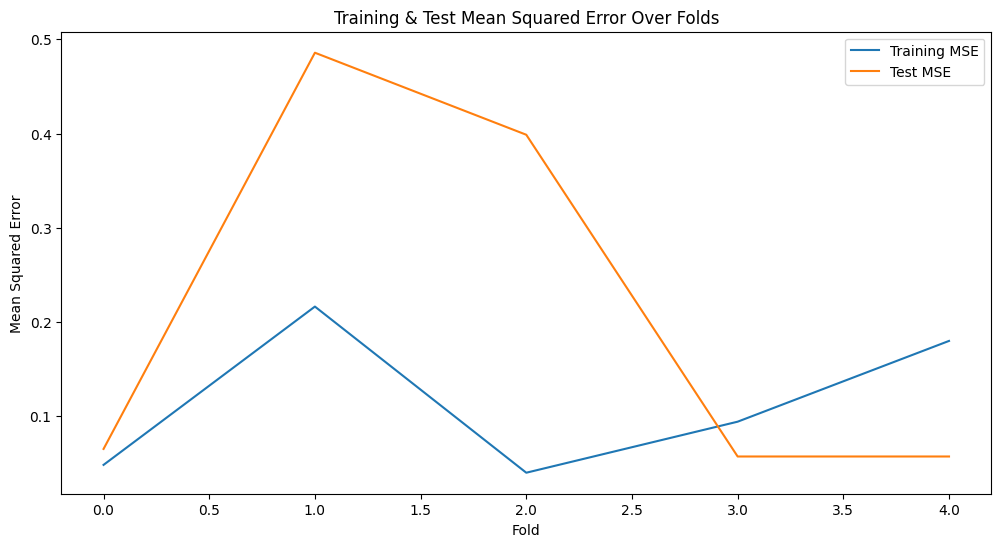

In [179]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_scores)), train_scores, label='Training MSE')
plt.plot(range(len(test_scores)), test_scores, label='Test MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Training & Test Mean Squared Error Over Folds')
plt.legend()
plt.show()

In [134]:
loaded_model = joblib.load('best_model.pkl')

print(X_test)
test_pred = loaded_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
print(f'Test Mean Squared Error: {test_mse}.')

    Temperature  Hour  Day  Month  Broken Clouds  Clear Sky  Few Clouds  \
13       273.81     3   10      3              0          0           0   
45       269.23     3   14      3              0          1           0   
47       273.28     9   14      3              0          1           0   
44       269.84     0   14      3              1          0           0   
17       275.97    15   10      3              0          0           0   
27       271.48    21   11      3              0          0           0   
26       271.92    18   11      3              0          0           0   
25       272.71    15   11      3              1          0           0   
31       272.51     9   12      3              0          0           0   
19       274.59    21   10      3              0          0           0   

    Light Snow  Overcast Clouds  Scattered Clouds  
13           0                1                 0  
45           0                0                 0  
47           0    

In [180]:
new_data = pd.DataFrame({
    'Temperature': [269.08],
    'Hour': [12],
    'Day': [15],
    'Month': [3],
    'Broken Clouds': [0],
    'Clear Sky': [1],
    'Few Clouds': [0],
    'Light Snow': [0],
    'Overcast Clouds': [0],
    'Scattered Clouds': [0],
})

y_pred = loaded_model.predict(new_data)
print(f'Predicted Action: {y_pred}.')

Predicted Action: [0.34].
